In [249]:
# importing libraries

import os
import cv2
import pytesseract
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [250]:
# utility function for displaying images

#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im):
    dpi = 150
    
    if isinstance(im, str) and os.path.isfile(im):
        im_data = plt.imread(im)
    elif isinstance(im, (np.ndarray, np.generic)):
        im_data = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    else:
        raise ValueError("Input must be a file path or image data array.")


    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')
    # ax.imshow(im_data)

    plt.show()

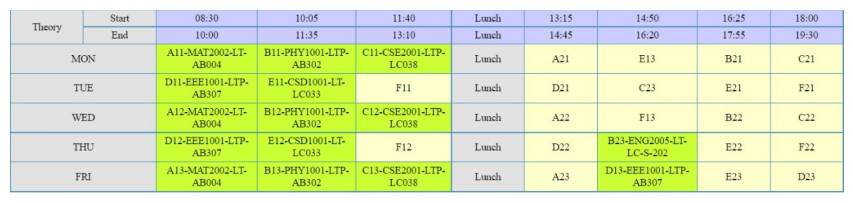

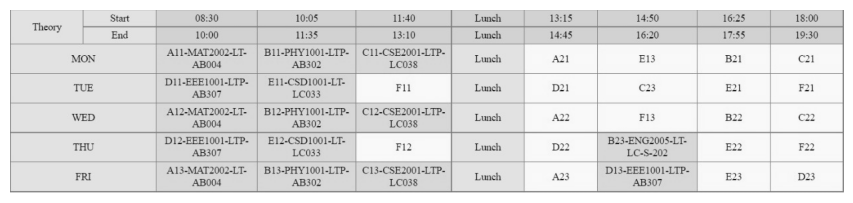

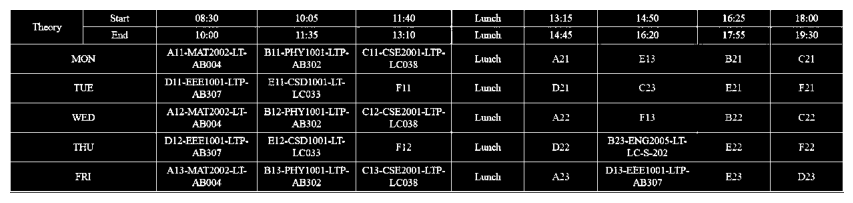

In [275]:
# reading the image

image = cv2.imread("./dataset/timetable1.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# thresholding the image
thresh = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2.imwrite("./temp/thresh.png", thresh)

display(image)
display(gray)
display(thresh)

In [252]:
# define the kernels

kernel_len = np.array(image).shape[1]//100

ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

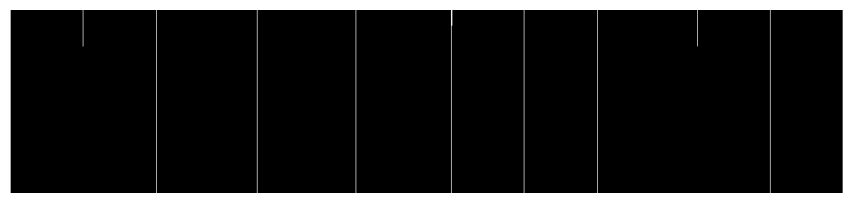

In [253]:
# get vertical lines
vertical_lines = cv2.erode(thresh, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(vertical_lines, ver_kernel, iterations=3)
# vertical_lines_thresh = cv2.threshold(vertical_lines, 230, 255, cv2.THRESH_BINARY)[1]
display(vertical_lines)

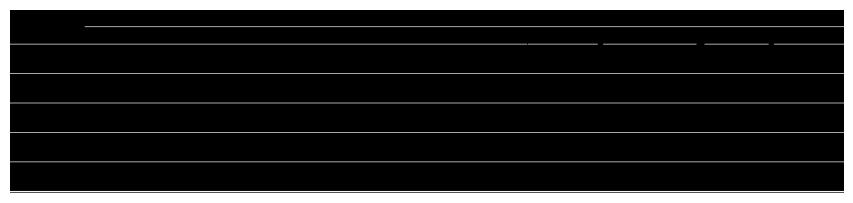

In [254]:
# get horizontal lines
horizontal_lines = cv2.erode(thresh, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=3)
# horizontal_lines_thresh = cv2.threshold(horizontal_lines, 230, 255, cv2.THRESH_BINARY)[1]
display(horizontal_lines)

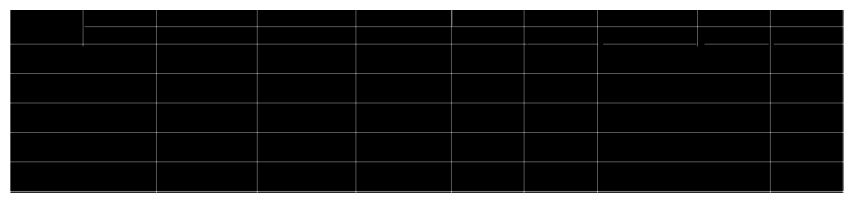

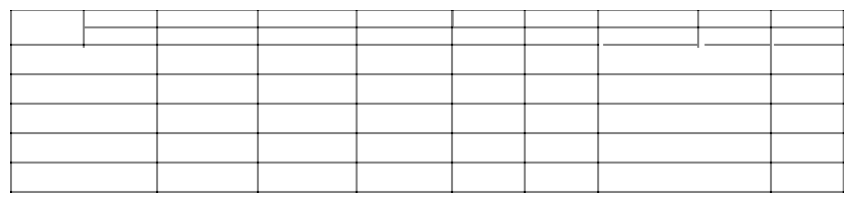

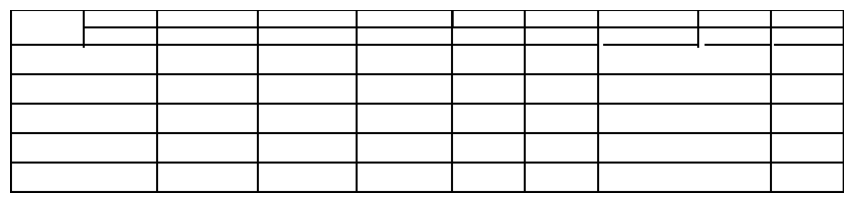

In [255]:
# merge the horizontal and vertical lines to get the grid
grid_vh = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)
display(grid_vh)
grid_vh = cv2.erode(~grid_vh, kernel, iterations=2)
display(grid_vh)
grid_vh = cv2.threshold(grid_vh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
display(grid_vh)

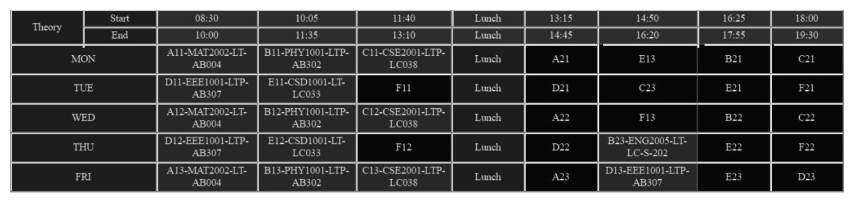

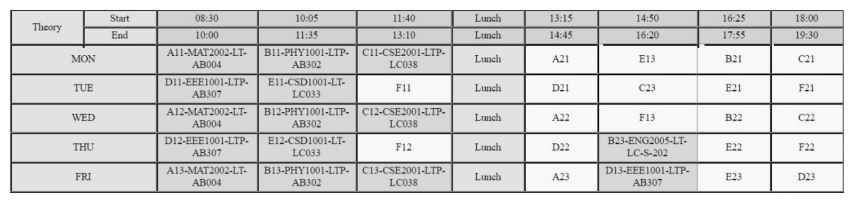

In [256]:
# xor and not the grid with the original image

grid_bitxor = cv2.bitwise_xor(gray, grid_vh)
display(grid_bitxor)
grid_bitnot = cv2.bitwise_not(grid_bitxor)
display(grid_bitnot)

In [257]:
# find the contours of the grid
contours, hierarchy = cv2.findContours(grid_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

In [258]:
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#Get mean of heights
mean = np.mean(heights)

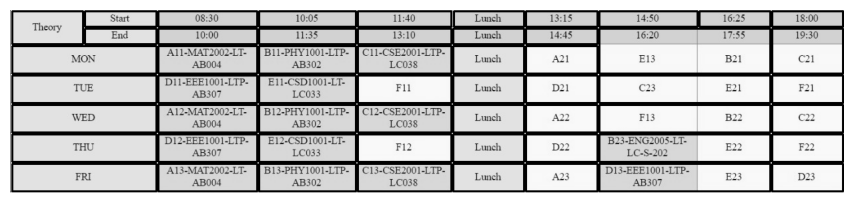

In [259]:
#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image_bb = cv2.rectangle(gray,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])

display(image_bb)

In [260]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0
#Sorting the boxes to their respective row and column
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous=box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]
            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
print(column)
print(row)


[[1142, 231, 106, 41], [883, 231, 256, 41], [773, 231, 107, 41], [664, 231, 106, 41], [521, 231, 140, 41], [373, 231, 145, 41], [222, 231, 148, 41], [3, 231, 216, 41]]
[[[1142, 3, 106, 23], [1033, 3, 106, 23], [883, 3, 147, 23], [773, 3, 107, 23], [665, 3, 105, 23], [521, 3, 140, 23], [373, 3, 145, 23], [222, 3, 148, 23], [112, 3, 107, 23], [3, 3, 106, 49]], [[1142, 29, 106, 67], [883, 29, 256, 67], [773, 29, 107, 23], [664, 29, 106, 23], [521, 29, 140, 23], [373, 29, 145, 23], [222, 29, 148, 23], [112, 29, 107, 23]], [[773, 55, 107, 41], [664, 55, 106, 41], [521, 55, 140, 41], [373, 55, 145, 41], [222, 55, 148, 41], [3, 55, 216, 41]], [[1142, 99, 106, 41], [883, 99, 256, 41], [773, 99, 107, 41], [664, 99, 106, 41], [521, 99, 140, 41], [373, 99, 145, 41], [222, 99, 148, 41], [3, 99, 216, 41]], [[1142, 143, 106, 41], [883, 143, 256, 41], [773, 143, 107, 41], [664, 143, 106, 41], [521, 143, 140, 41], [373, 143, 145, 41], [222, 143, 148, 41], [3, 143, 216, 41]], [[1142, 187, 106, 41], [88

In [261]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center=np.array(center)
center.sort()

In [262]:
#Regarding the distance to the columns center, the boxes are arranged in respective order
finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


In [263]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=""
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = grid_bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)


In [264]:
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
print(dataframe)
data = dataframe.style.set_properties(align="left")

                   0                           1                           2  \
0   Start\n Theory\n                     08:30\n                     10:05\n   
1              End\n                     10:00\n                     11:35\n   
2              MON\n   Al1-MAT2002-LT-\nABO004\n   B11-PHY1001-LTP-\nAB302\n   
3                      D11-EEE1001-LTP-\nAB307\n    E11-CSD1001-LT-\nLC033\n   
4                       A12-MAT2002-LT-\nAB004\n   B12-PHY1001-LTP-\nAB302\n   
5                      D12-EEE1001-LTP-\nAB307\n    E12-CSD1001-LT-\nLC033\n   
6                      A13-MAT2002-LT-\nABO004\n   B13-PHY1001-LTP-\nAB302\n   

                            3         4         5  \
0                     11:40\n   Lunch\n   13:15\n   
1                     13:10\n   Lunch\n   14:45\n   
2   C11-CSE2001-LTP-\nLC038\n   Lunch\n             
3                       Fil\n   Lunch\n     D21\n   
4   C12-CSE2001-LTP-\nLC038\n   Lunch\n       &\n   
5                       F12\n   Lunch\n  